## Data Preprocessing and Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import sys
from typing import List

if sys.version_info < (3, 8):
    from typing_extensions import Final
else:
    from typing import Final

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kraks\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Dataset 1: Finacial Alpaca Dataset:

In [2]:
# loading dataset from huggingface

fin_alpcha_df = pd.read_json("hf://datasets/gbharti/finance-alpaca/Cleaned_date.json")
fin_alpcha_df.head()

c:\Users\kraks\anaconda3\envs\py39-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,instruction,input,output,text
0,"For a car, what scams can be plotted with 0% f...",,The car deal makes money 3 ways. If you pay in...,
1,Why does it matter if a Central Bank has a neg...,,"That is kind of the point, one of the hopes is...",
2,Where should I be investing my money?,,"Pay off your debt. As you witnessed, no ""inve...",
3,Specifically when do options expire?,,"Equity options, at least those traded in the A...",
4,Negative Balance from Automatic Options Exerci...,,"Automatic exercisions can be extremely risky, ...",


In [3]:
fin_alpcha_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68912 entries, 0 to 68911
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  68912 non-null  object
 1   input        68912 non-null  object
 2   output       68912 non-null  object
 3   text         68912 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [4]:
fin_alpcha_df.isna().sum()

instruction    0
input          0
output         0
text           0
dtype: int64

In [5]:
# Text Cleaning Functions
def clean_extra_whitespace(text: str) -> str:
    """Cleans extra whitespace characters that appear between words.
    """
    cleaned_text = re.sub(r"[\xa0\n]", " ", text)
    cleaned_text = re.sub(r"([ ]{2,})", " ", cleaned_text)
    return cleaned_text.strip()

def clean_dashes(text: str) -> str:
    """Cleans dash characters in text."""
    return re.sub(r"[-\u2013]", " ", text).strip()

def clean_bullets(text: str) -> str:
    """Cleans unicode bullets from a section of text."""
    UNICODE_BULLETS: Final[List[str]] = [ "\u0095", "\u2022", "\u2023", "\u2043", "\u3164", "\u204C", "\u204D", "\u2219", "\u25CB", "\u25CF", "\u25D8", "\u25E6", "\u2619", "\u2765", "\u2767",
                                            "\u29BE", "\u29BF", "\u002D", "", r"\*", "\x95", "·",]
    BULLETS_PATTERN = "|".join(UNICODE_BULLETS)
    UNICODE_BULLETS_RE = re.compile(f"(?:{BULLETS_PATTERN})(?!{BULLETS_PATTERN})") 
    search = UNICODE_BULLETS_RE.match(text)
    if search is None:
        return text

    cleaned_text = UNICODE_BULLETS_RE.sub("", text, 1)
    return cleaned_text.strip()

def clean_non_ascii_chars(text) -> str:
    """Cleans non-ascii characters from unicode string."""
    en = text.encode("ascii", "ignore")
    return en.decode()

def clean(text: str, extra_whitespace: bool = False, dashes: bool = False, bullets: bool = False, lowercase: bool = False, non_ascii: bool = False) -> str:    
    """Function that cleans text. """

    cleaned_text = text.lower() if lowercase else text
    cleaned_text = clean_dashes(cleaned_text) if dashes else cleaned_text
    cleaned_text = clean_extra_whitespace(cleaned_text) if extra_whitespace else cleaned_text
    cleaned_text = clean_bullets(cleaned_text) if bullets else cleaned_text
    cleaned_text = clean_non_ascii_chars(cleaned_text) if non_ascii else cleaned_text
    return cleaned_text.strip()


In [6]:
# clean the dataset
fin_alpcha_df["output_cleaned"] = fin_alpcha_df["output"].apply(clean, extra_whitespace=True, dashes=True, bullets=True, non_ascii=True)
fin_alpcha_df["input_cleaned"] = fin_alpcha_df["input"].apply(clean, extra_whitespace=True, dashes=True, bullets=True, non_ascii=True)

### Dataset 2: Fintalk-19k

In [7]:
fintalk_df = pd.read_json("hf://datasets/ceadar-ie/FinTalk-19k/FinTalk-19k.jsonl", lines=True)
fintalk_df.head()

,instruction,response,context,tag
0,What are some job ideas for a 62-year-old man ...,Truck driving can be a lucrative career and ca...,The person asking the question is a relative o...,Personal Finance
1,What is an appropriate way to respond when a c...,Respecting coworkers' wishes is appropriate. A...,The coworker has expressed that they cannot af...,Personal Finance
2,How can you learn to live with accumulated wea...,The struggle with managing wealth and feeling ...,The author has recently experienced a signific...,Personal Finance
3,How will the shift to working from home affect...,The shift to working from home has the potenti...,The text discusses the potential benefits and ...,Personal Finance
4,What are some tips for paying off student loan...,"Based on personal experience, here are some ti...",The author paid off their student loans after ...,Personal Finance


In [8]:
fintalk_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19111 entries, 0 to 19110
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  19111 non-null  object
 1   response     19111 non-null  object
 2   context      19111 non-null  object
 3   tag          19111 non-null  object
dtypes: object(4)
memory usage: 597.3+ KB


In [9]:
fintalk_df.isna().sum()

instruction    0
response       0
context        0
tag            0
dtype: int64

In [10]:
# distribution of tag column in fintalk dataset
pd.DataFrame(fintalk_df["tag"].value_counts())

,count
tag,
Personal Finance,17774
Public Sentiment,775
Financial Information,562


In [11]:
# clean the dataset
fintalk_df["context_cleaned"] = fintalk_df["context"].apply(clean, extra_whitespace=True, dashes=True, bullets=True, non_ascii=True)
fintalk_df["response_cleaned"] = fintalk_df["response"].apply(clean, extra_whitespace=True, dashes=True, bullets=True, non_ascii=True)

In [12]:
fintalk_df.head()

,instruction,response,context,tag,context_cleaned,response_cleaned
0,What are some job ideas for a 62-year-old man ...,Truck driving can be a lucrative career and ca...,The person asking the question is a relative o...,Personal Finance,The person asking the question is a relative o...,Truck driving can be a lucrative career and ca...
1,What is an appropriate way to respond when a c...,Respecting coworkers' wishes is appropriate. A...,The coworker has expressed that they cannot af...,Personal Finance,The coworker has expressed that they cannot af...,Respecting coworkers' wishes is appropriate. A...
2,How can you learn to live with accumulated wea...,The struggle with managing wealth and feeling ...,The author has recently experienced a signific...,Personal Finance,The author has recently experienced a signific...,The struggle with managing wealth and feeling ...
3,How will the shift to working from home affect...,The shift to working from home has the potenti...,The text discusses the potential benefits and ...,Personal Finance,The text discusses the potential benefits and ...,The shift to working from home has the potenti...
4,What are some tips for paying off student loan...,"Based on personal experience, here are some ti...",The author paid off their student loans after ...,Personal Finance,The author paid off their student loans after ...,"Based on personal experience, here are some ti..."


### Merging the datasets
### Extracting finance Q&A pairs based on embeddings from the finance alpaca dataset

### Hypothesis 1: "Instructions in the dataset can be grouped into distinct clusters of similar topics to extract Q&A pairs of personal finance."


Steps:
1. Converting the instructions into numerical form: Using `sentenceTransformer` to convert instructions to numerical data.

2. Performing clustering: Apply a clustering algorithm like KMeans or Hierarchical Clustering to group similar instructions.

3. Visualize the clusters: Using t-SNE to reduce the dimensionality of the data and plot the clusters.

c:\Users\kraks\anaconda3\envs\py39-gpu\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


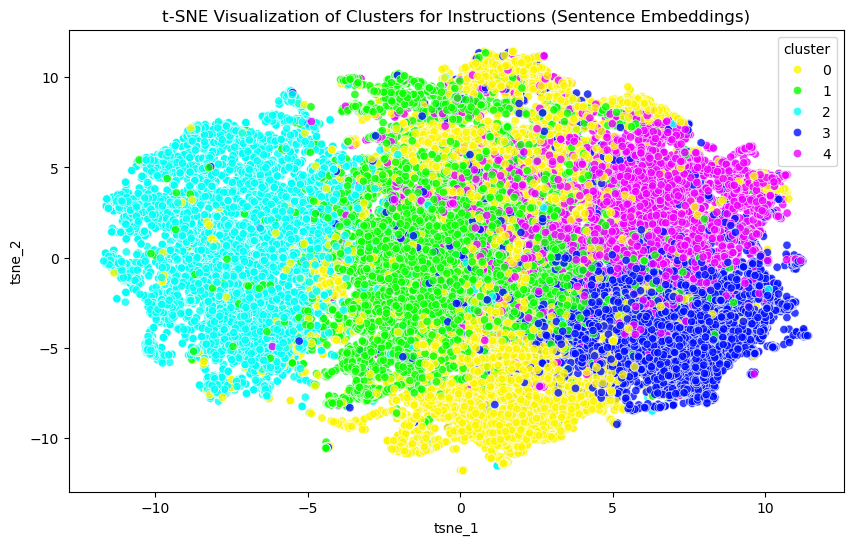


Cluster 0 Representative Instructions:
["Identify the homophone of the word 'knight'."
 'How many hours is 1.4 days.'
 'Calculate the median of this set of numbers.' 'Describe a home kitchen'
 'Compile a list of popular books that were released this year.']

Cluster 1 Representative Instructions:
['Create a list of ten slang terms related to the internet.'
 'Generate two possible questions a customer might ask related to the product.'
 'Name a constitutional amendment.'
 'How would you create a website similar to Reddit?'
 'Suggest some tips to motivate yourself when you cannot find the right kind of motivation.']

Cluster 2 Representative Instructions:
['Fees aside, what factors could account for performance differences between U.S. large-cap index ETFs?'
 'Does it make sense to buy a house in my situation?'
 'How do owners in a partnership earn income?'
 'Could an ex-employee of a company find themself stranded with shares they cannot sell (and a tax bill)?'
 'Bank of the Sierra: Ar

In [13]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer

# Assuming your dataframe is named qa_df and has 'instruction' column

# Step 1: Load a pre-trained model for sentence embeddings (e.g., 'all-MiniLM-L6-v2')
model = SentenceTransformer('all-MiniLM-L6-v2')

# Step 2: Generate sentence embeddings for the 'instruction' column
instruction_embeddings = model.encode(fin_alpcha_df['instruction'].astype(str).tolist())

# Step 3: Perform KMeans clustering on the sentence embeddings
num_clusters = 5  # You can experiment with the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
fin_alpcha_df['cluster'] = kmeans.fit_predict(instruction_embeddings)

# Step 4: Use t-SNE for dimensionality reduction to 2D for visualization
tsne = TSNE(n_components=2, perplexity=40, max_iter=300, random_state=42)
tsne_results = tsne.fit_transform(instruction_embeddings)

fin_alpcha_df['tsne_1'] = tsne_results[:, 0]
fin_alpcha_df['tsne_2'] = tsne_results[:, 1]

# Step 5: Plot the t-SNE results with clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', palette=sns.color_palette("hsv", num_clusters),
                data=fin_alpcha_df, legend="full", alpha=0.8)
plt.title('t-SNE Visualization of Clusters for Instructions (Sentence Embeddings)')
plt.show()

# Step 6: Inspect representative instructions for each cluster
for cluster in range(num_clusters):
    print(f"\nCluster {cluster} Representative Instructions:")
    print(fin_alpcha_df[fin_alpcha_df['cluster'] == cluster]['instruction'].sample(5, random_state=42).values)


In [14]:
# extract all questions and answers pairs from cluster 2 and save them to a dataframe
fin_alpcha_df = fin_alpcha_df[fin_alpcha_df['cluster'] == 2]
fin_alpcha_df.shape

(17501, 9)

In [15]:
# renaming columns to keep consistency
fin_alpcha_df = fin_alpcha_df.rename(columns={"output_cleaned": "response_cleaned", "input_cleaned": "context_cleaned", "input": "context", "output": "response"})

# concatenate both datasets
qa_df = pd.concat([fintalk_df, fin_alpcha_df], ignore_index=True)

In [16]:
qa_df.head()

,instruction,response,context,tag,context_cleaned,response_cleaned,text,cluster,tsne_1,tsne_2
0,What are some job ideas for a 62-year-old man ...,Truck driving can be a lucrative career and ca...,The person asking the question is a relative o...,Personal Finance,The person asking the question is a relative o...,Truck driving can be a lucrative career and ca...,NaN,NaN,NaN,NaN
1,What is an appropriate way to respond when a c...,Respecting coworkers' wishes is appropriate. A...,The coworker has expressed that they cannot af...,Personal Finance,The coworker has expressed that they cannot af...,Respecting coworkers' wishes is appropriate. A...,NaN,NaN,NaN,NaN
2,How can you learn to live with accumulated wea...,The struggle with managing wealth and feeling ...,The author has recently experienced a signific...,Personal Finance,The author has recently experienced a signific...,The struggle with managing wealth and feeling ...,NaN,NaN,NaN,NaN
3,How will the shift to working from home affect...,The shift to working from home has the potenti...,The text discusses the potential benefits and ...,Personal Finance,The text discusses the potential benefits and ...,The shift to working from home has the potenti...,NaN,NaN,NaN,NaN
4,What are some tips for paying off student loan...,"Based on personal experience, here are some ti...",The author paid off their student loans after ...,Personal Finance,The author paid off their student loans after ...,"Based on personal experience, here are some ti...",NaN,NaN,NaN,NaN


In [17]:
# convert all NaN values to empty strings
qa_df = qa_df.fillna("")

## Exploratory Data Analysis

### Exploratory Data Analysis 1 - Token distribution analysis

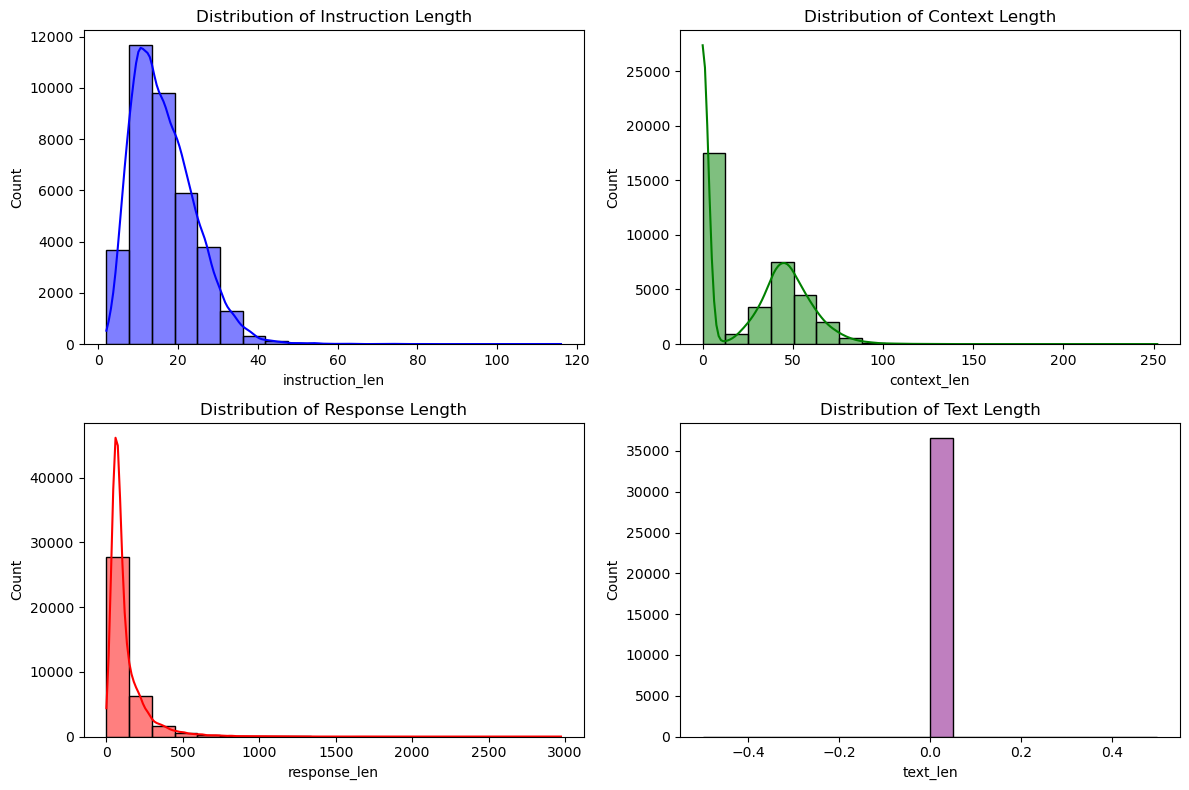

In [18]:
# Function to get the length of text in each column
def text_length(text):
    return len(text.split())

# 1. Distribution of text length in different columns
qa_df['instruction_len'] = qa_df['instruction'].apply(text_length)
qa_df['context_len'] = qa_df['context'].apply(text_length)
qa_df['response_len'] = qa_df['response'].apply(text_length)
qa_df['text_len'] = qa_df['text'].apply(text_length)

# Plot distribution of text lengths
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
sns.histplot(qa_df['instruction_len'], bins=20, kde=True, color='blue')
plt.title('Distribution of Instruction Length')

plt.subplot(2, 2, 2)
sns.histplot(qa_df['context_len'], bins=20, kde=True, color='green')
plt.title('Distribution of Context Length')

plt.subplot(2, 2, 3)
sns.histplot(qa_df['response_len'], bins=20, kde=True, color='red')
plt.title('Distribution of Response Length')

plt.subplot(2, 2, 4)
sns.histplot(qa_df['text_len'], bins=20, kde=True, color='purple')
plt.title('Distribution of Text Length')

plt.tight_layout()
plt.show()


### Exploratory Data Analysis 2 - Word Clouds

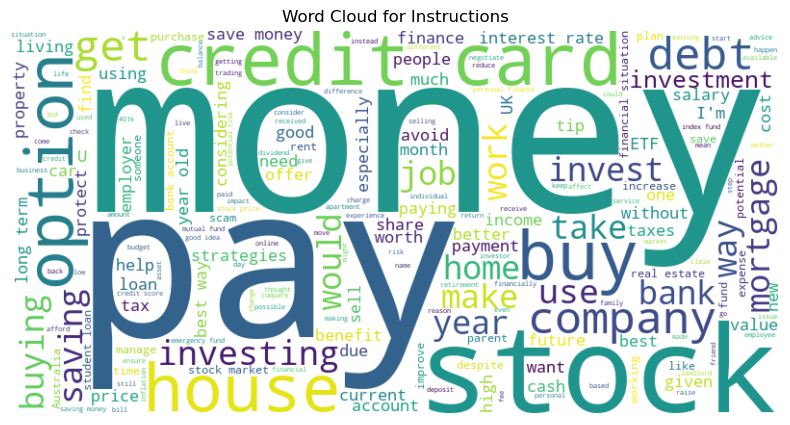

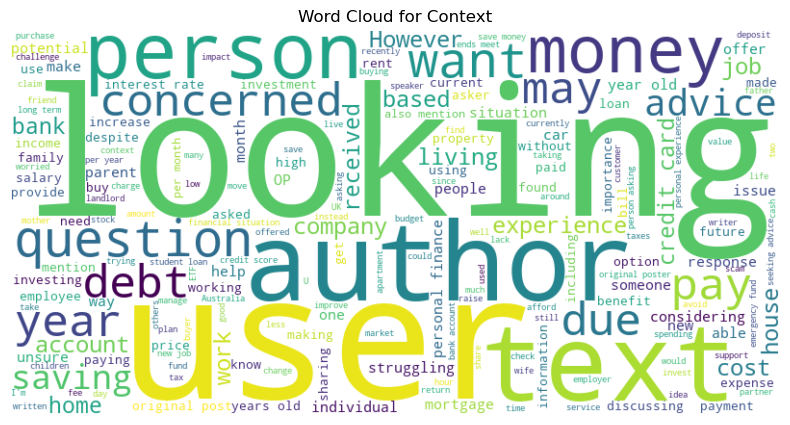

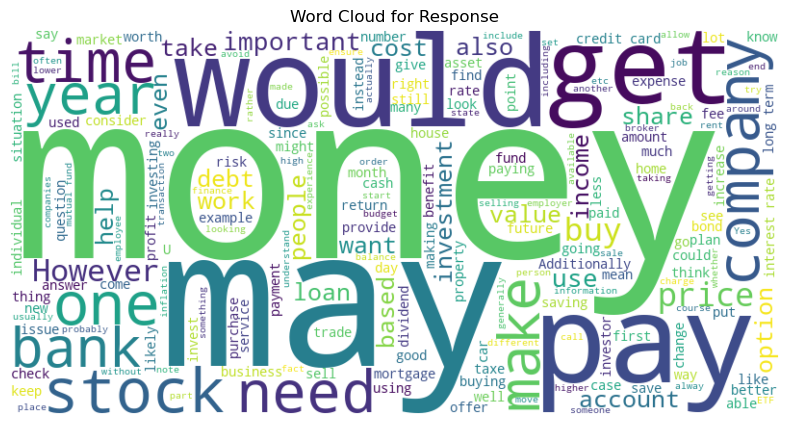

In [19]:
# 2. Word Cloud for each column to understand frequent words
stop_words = set(stopwords.words('english'))

def generate_wordcloud(text_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(' '.join(text_data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate word clouds for each column
generate_wordcloud(qa_df['instruction'], 'Word Cloud for Instructions')
generate_wordcloud(qa_df['context_cleaned'], 'Word Cloud for Context')
generate_wordcloud(qa_df['response_cleaned'], 'Word Cloud for Response')

### Exploratory Data Analysis 3 - Pairwise comparision of text length to uncover relationships between features

<Figure size 1000x600 with 0 Axes>

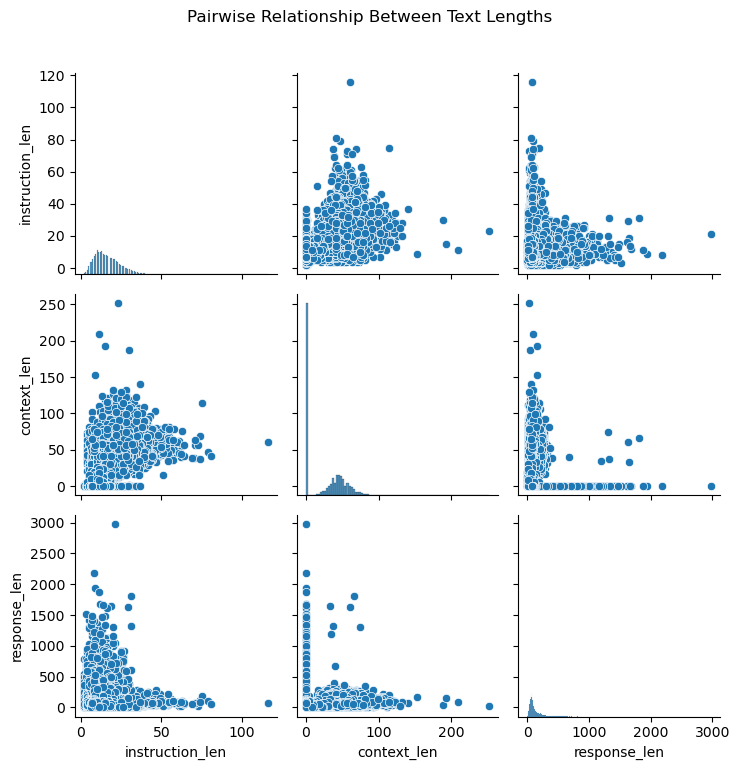

In [20]:
# 3. Pairwise comparison of text length to see any relationships
plt.figure(figsize=(10, 6))
sns.pairplot(qa_df[['instruction_len', 'context_len', 'response_len']])
plt.suptitle('Pairwise Relationship Between Text Lengths', y=1.02)  # Adjust y value to position the title
plt.tight_layout()
plt.show()

### Exploratory Data Analysis 4
### Hypothesis 2 - Longer instruction (question) lengths lead to longer response (answer) lenghts

Proof and Analysis:
1. Scatter Plot Visualization: A scatter plot is created to visually inspect the relationship between the lengths of the instruction and output text. If the points tend to form an upward trend, this would suggest a positive relationship, meaning that as the instruction length increases, the output length also increases.

2. Pearson Correlation Coefficient: The Pearson correlation coefficient (r) is calculated to quantify the strength and direction of the relationship between the lengths of the instruction and output. The correlation coefficient can range from:

    +1: Strong positive correlation

    0: No correlation

    -1: Strong negative correlation

    A high positive value (closer to +1) would confirm that longer instructions lead to longer outputs.

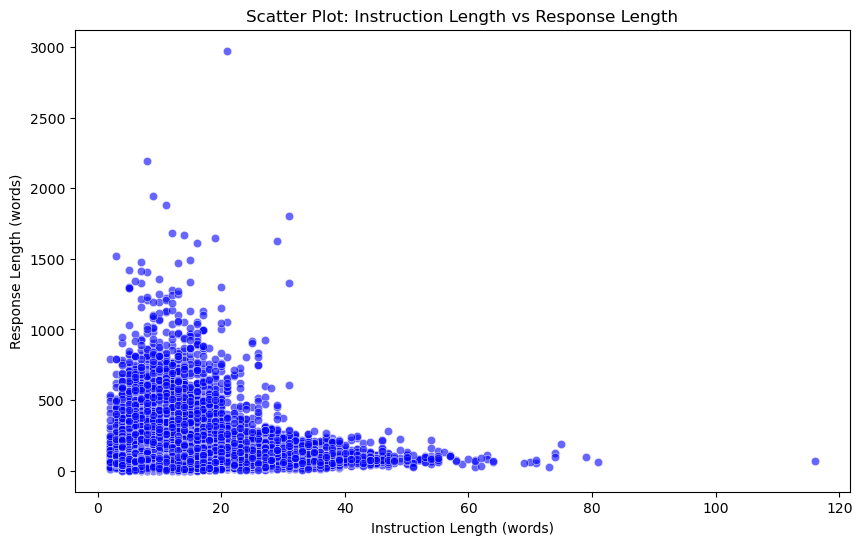

Pearson Correlation Coefficient between Instruction and Response Length: -0.22


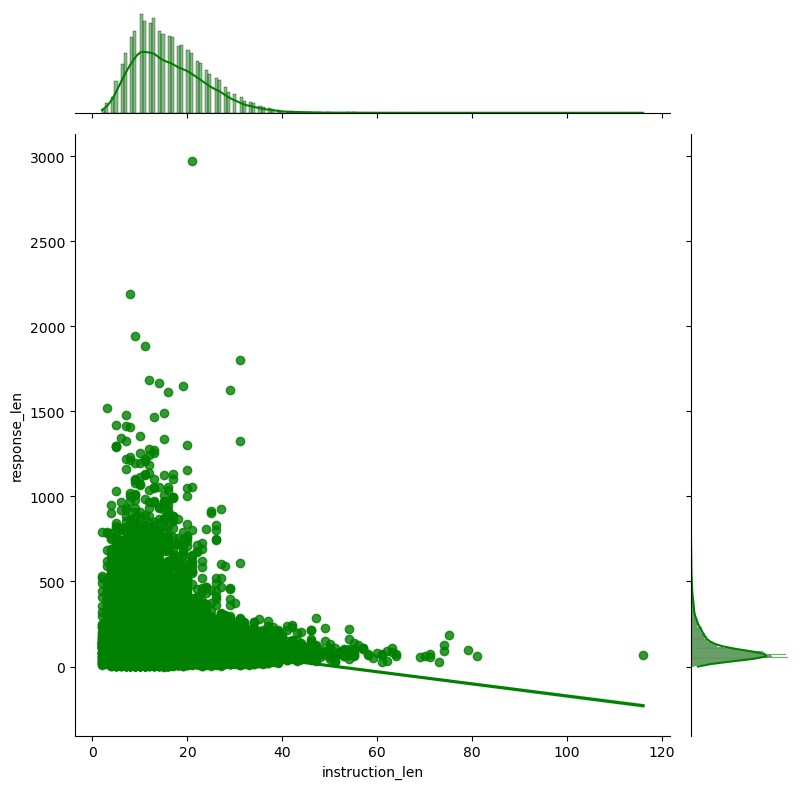

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataframe is named qa_df and has 'instruction' and 'response' columns
# Calculate the length of instructions and outputs
qa_df['instruction_len'] = qa_df['instruction'].apply(lambda x: len(str(x).split()))
qa_df['response_len'] = qa_df['response'].apply(lambda x: len(str(x).split()))

# 1. Scatter plot to visualize the correlation
plt.figure(figsize=(10, 6))
sns.scatterplot(x='instruction_len', y='response_len', data=qa_df, color='blue', alpha=0.6)
plt.title('Scatter Plot: Instruction Length vs Response Length')
plt.xlabel('Instruction Length (words)')
plt.ylabel('Response Length (words)')
plt.show()

# 2. Calculate the Pearson correlation coefficient
correlation = qa_df['instruction_len'].corr(qa_df['response_len'])
print(f'Pearson Correlation Coefficient between Instruction and Response Length: {correlation:.2f}')

# 3. (Optional) Jointplot with regression line for detailed view
sns.jointplot(x='instruction_len', y='response_len', data=qa_df, kind='reg', height=8, color='green')
plt.show()


### Word Embedding Analysis

In [22]:
import pandas as pd
import re
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Preprocess the text (tokenization, lowercasing, and removing punctuation)
def preprocess_text(text):
    # Remove special characters and lowercase the words
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Tokenize the words
    tokens = text.split()
    return tokens

# Apply preprocessing to each instruction
qa_df['instruction_tokens'] = qa_df['instruction'].apply(preprocess_text)

# Step 2: Train a Word2Vec model
# Using size=100 for 100-dimensional embeddings
word2vec_model = Word2Vec(sentences=qa_df['instruction_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# Step 3: Find the vocabulary and most similar words to a sample term
vocab = list(word2vec_model.wv.index_to_key)
print("Vocabulary Size: ", len(vocab))

# Find the top 10 most similar words for a sample word (e.g., "loan")
print("\nTop 10 words similar to 'loan':")
print(word2vec_model.wv.most_similar('loan', topn=10))

# Step 4: Dimensionality reduction (t-SNE) for visualization of word vectors
def plot_word_embeddings(word_list, model):
    word_vectors = [model.wv[word] for word in word_list]
    
    # Perform t-SNE to reduce to 2D
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
    word_vectors_tsne = tsne.fit_transform(word_vectors)
    
    # Create a DataFrame for plotting
    df = pd.DataFrame(word_vectors_tsne, index=word_list, columns=['x', 'y'])
    
    # Plot the embeddings
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='x', y='y', data=df)
    
    # Annotate the points with the corresponding words
    for word, pos in df.iterrows():
        plt.annotate(word, pos, fontsize=12)
    plt.title('t-SNE Visualization of Word Embeddings')
    plt.show()

# Step 5: Choose some words for visualization
words_to_visualize = ['loan', 'money', 'investment', 'stock', 'trading' ,'interest', 'debt', 'payment', 'risk', 'finance', 'car', 'bank']
plot_word_embeddings(words_to_visualize, word2vec_model)


Vocabulary Size:  14063

Top 10 words similar to 'loan':
[('loans', 0.8205686211585999), ('mortgage', 0.7707790732383728), ('cash', 0.7280156016349792), ('refinanced', 0.6924893260002136), ('principal', 0.6820806264877319), ('payment', 0.6818360686302185), ('borrower', 0.675462007522583), ('refinance', 0.6580497026443481), ('debt', 0.6558840870857239), ('lease', 0.6493126153945923)]


c:\Users\kraks\anaconda3\envs\py39-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


AttributeError: 'list' object has no attribute 'shape'

In [24]:
# write to json file
columns_to_keep = ['instruction', 'context', 'context_cleaned', 'response', 'response_cleaned', 'tag']
qa_df = qa_df[columns_to_keep]
qa_df.to_json("qa_data.json", orient='records', lines=True)